# Unsupervised Learning: Clustering Lab





In [44]:
from sklearn.base import BaseEstimator, ClassifierMixin, ClusterMixin
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import preprocessing
from scipy.spatial.distance import cdist
from scipy.io import arff
import numpy as np
import matplotlib.pyplot as plt
import pdb
import pandas as pd
import copy

## 1. (50%) Implement the k-means clustering algorithm and the HAC (Hierarchical Agglomerative Clustering) algorithm.

### 1.1.1 HAC

### Code requirements 
- HAC should support both single link and complete link options.
- HAC automatically generates all clusterings from n to 1.  To simplify the amount of output you may want to implement a mechanism to specify for which k values actual output will be generated.


---
The output should include the following:
- The number of clusters (k).
- The total SSE of the full clustering. 


For each cluster report include:


- The centroid id - "Cluster centroid ~ the mean of the data points in the cluster"
- The number of instances tied to that centroid. 
* The SSE of that cluster. (The sum squared error (SSE) of a single cluster is the sum of the squared euclidean distance of each cluster member to the cluster centroid.)
---
You only need to handle continuous features

In [45]:
def is_equal(a, b):
    #pdb.set_trace()
    if len(a) != len(b):
        return False
    if len(a) == 1:
        return np.array_equal(a, b)
    if len(a) > 1:
        for i in range(len(a)):
            if np.array_equal(a[i], b[i]):
                return True
    
    return False


In [46]:
class HACClustering(BaseEstimator, ClusterMixin):

    def __init__(self,k=3,link_type='single'): ## add parameters here
        """
        Args:
            k = how many final clusters to have
            link_type = single or complete. when combining two clusters use complete link or single link
        """
        self.link_type = link_type
        self.k = k

    def fit(self,X,y=None):
        """ Fit the data; In this lab this will make the K clusters :D
        Args:
            X (array-like): A 2D numpy array with the training data
            y (array-like): An optional argument. Clustering is usually unsupervised so you don't need labels
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        # Initialize 
        # Generate distance matrix

        self.num_vals = len(X[0])
        distances = np.array([np.linalg.norm(X - p, ord=2, axis=1) for p in X])
        self.clusters = [[point] for point in X]
        while len(self.clusters) != self.k:
            # if len(self.clusters) == 3:
            #     pdb.set_trace()
            link = self.single_link(distances)
            base_cluster = self.clusters[link[0]]
            cluster_to_merge = self.clusters[link[1]]

            for i, clust in enumerate(self.clusters):
                if is_equal(base_cluster, clust):
                    self.clusters.pop(i)
                    break
      
            for i, clust in enumerate(self.clusters):
                if is_equal(cluster_to_merge, clust):
                    self.clusters.pop(i)
                    break;
   
            for point in cluster_to_merge:
                base_cluster.append(point) # Combine clusters (1 and 3)
 
            self.clusters.append(base_cluster) # Add on new combined cluster to the end
            #print("\nUpdated Clusters:\n", self.clusters)
            # if self.link_type == 'single':
            #     distances = self.merge_single(link, distances)
            # else:
            #     distances = self.merge_complete(link, distances)
            distances = self.merge(link, distances) # remake the distances matrix by taking out the row and col of the 

        self.centroid_list = [sum(self.clusters[i]) / len(self.clusters[i]) for i in range(len(self.clusters))]
        self.sse = [np.sum((self.clusters[i] - self.centroid_list[i]) ** 2) for i in range(len(self.clusters))]
        self.total_sse = np.sum(self.sse)

        return self
    
    def calc_centroid(self, cluster):
        centroid = np.zeros(len(cluster[0]))
        #pdb.set_trace()
        for point in cluster:
            for i in range(len(point)):
                #pdb.set_trace()
                centroid[i] += point[i]
        for i, val in enumerate(centroid):
            centroid[i] = centroid[i] / len(cluster)
        return centroid

    def calc_sse(self, cluster):
        #pdb.set_trace()
        centroid = np.mean(cluster)
        sse = np.sum(np.linalg.norm(cluster - centroid, axis = 1) ** 2)
        return sse

    # Returns the indexes [i,j] to the smallest distance in the distance matrix
    def single_link(self, distances):
        d = copy.deepcopy(distances)
        #pdb.set_trace()
        # We don't want to look at the zeros so set them to inf.
        d = np.where(d==0, np.inf, d) # np.where(condition[,x,y] -> returns elements chosen from x or y depending on condition
        temp = np.unravel_index(d.argmin(), d.shape) # (indices, shape, order='C') Converts a flat index or array of flat indices into a tuple of coordinate arrays
        return temp # get the index of the smallest point in matrix
    
    def complete_link(self, distances):
        pdb.set_trace()
        d = copy.deepcopy(distances)
        temp = np.unravel_index(d.argmax(), d.shape) # (indices, shape, order='C') Converts a flat index or array of flat indices into a tuple of coordinate arrays
        return temp # get the index of the largest point in matrix

    def merge_single(self, link, distances):
        n = distances.shape[0]
        m = np.array([distances[link[0]], distances[link[1]]]) #2 cols to compare
        m = np.min(m, axis=0)
        indices = np.where(m == 0)
        m = np.delete(m, indices[0][:2])
        m = np.expand_dims(m, 0)

    def merge_complete(self, link, distance):
        n = distances.shape[0]
        m = np.array([distances[link[0]], distances[link[1]]]) #2 cols to compare
        m = np.max(m, axis=0)
        indices = np.where(m == 0)
        m = np.delete(m, indices[0][:2])
        m = np.expand_dims(m, 0)

    def merge(self, link, distances):
        n = distances.shape[0] # Get the correct shape of the distance matrix
        m = np.array([distances[link[0]], distances[link[1]]]) # get the distances(row) for cluster 1 and the distances(row) for cluster 3
        
        if self.link_type == 'single':
            m = np.min(m, axis=0) ##### Getting the minimum dist (Single link) #### for each of the columns (take the one with the shortest distance to all the other cols)
        else:
            m = np.max(m, axis=0) ### Get the maximum distance for each of the cols 
        
        #m = np.expand_dims(m[m != 0], 0) # Add a dimension on the outside, this m[m != 0] is getting rid of the zeros (collapsing the zeros)
        m = np.delete(m, link) # Delete the two extra columns
        # Delete two rows
        distances = np.delete(distances, link, axis=0) # Delete row 1 and 3 from the distances matrix
        # Delete two columns
        distances = np.delete(distances, link, axis=1) # then delete the columns 1 and 3
        distances = np.reshape(distances, (n -2, n-2))
        # Add a column
        # Add the new vector m (the distances for our combined cluster)
        distances = np.c_[distances, m.T] # Add that new vector to the end and at the bottom
        m = np.expand_dims(np.append(m, 0),0)
        # Add a row
        distances = np.r_[distances, m]
        # our distance matrix now has a new row and column at the right and on the bottom.
        return distances
    
    def print_clusters(self):
        """
            Used for grading.
        """
        print("K = {:d}".format(self.k))
        print("Total SSE: {:.4f}".format(self.total_sse))
        
        for i, cluster in enumerate(self.clusters):
            print(np.array2string(self.centroid_list[i],precision=4,separator=","))
            print("Number of Points in Cluster: {:d}".format(len(cluster)))
            print("Cluster SSE: {:.4f}\n\n".format(self.sse[i]))   
        return

Using HW data

In [47]:
x = np.array([
              [.2,.3],
              [.1, .2],
              [.5, .9],
              [.9, .4],
              [-.2, .1],
])
hac = HACClustering(1, 'single').fit(x).print_clusters()


K = 1
Total SSE: 1.0880
[0.3 ,0.38]
Number of Points in Cluster: 5
Cluster SSE: 1.0880




### 1.1.2 Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff)


---
The dataset was modified to be a lot smaller. The last datapoint should be on line 359 or the point 0.585,0.46,0.185,0.922,0.3635,0.213,0.285,10. The remaining points should be commented out.



- Normalize Data
- K = 5
- Use the first k instances as the initial centroids
- Use 4 decimal places and DO NOT ROUND when reporting SSE and centroid values.


---
Solutions in files:

[Debug HAC Single.txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20HAC%20Single%20Link.txt)

[Debug HAC Complete.txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20HAC%20Complete%20Link.txt)

In [48]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff --output snail-data.arff
train_data = arff.loadarff('snail-data.arff')
df = pd.DataFrame(train_data[0])
data = np.array(df)

min_max_scaler = preprocessing.MinMaxScaler()
normalized_data = min_max_scaler.fit_transform(data)
X_with_labels = copy.deepcopy(normalized_data)
X_with_labels2 = copy.deepcopy(normalized_data)
X = data[:, 0:-1]
labels = data[:, -1]

print("----------HAC SINGLE---------- ")
hac = HACClustering(5, 'single').fit(X_with_labels).print_clusters()
print("----------HAC COMPLETE ----------")
hac = HACClustering(5, 'complete').fit(X_with_labels).print_clusters()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  187k  100  187k    0     0   881k      0 --:--:-- --:--:-- --:--:--  881k
----------HAC SINGLE---------- 
K = 5
Total SSE: 54.4392
[0.9189,0.9438,0.7105,0.7016,0.759 ,0.7222,0.4472,0.8824]
Number of Points in Cluster: 1
Cluster SSE: 0.0000


[1.    ,0.9888,0.7895,1.    ,1.    ,0.8915,0.7186,0.5882]
Number of Points in Cluster: 1
Cluster SSE: 0.0000


[0.9189,0.9888,0.8684,0.719 ,0.5797,0.7512,0.6432,0.9412]
Number of Points in Cluster: 1
Cluster SSE: 0.0000


[1.    ,0.9831,0.8026,0.8343,0.6575,0.7825,0.9221,0.8824]
Number of Points in Cluster: 2
Cluster SSE: 0.0475


[0.599 ,0.5923,0.4915,0.2826,0.2682,0.2921,0.2316,0.3849]
Number of Points in Cluster: 195
Cluster SSE: 54.3917


----------HAC COMPLETE ----------
K = 5
Total SSE: 13.0824
[0.7622,0.7658,0.6759,0.4265,0.4016,0.4536,0.3376,0.5217]
Number of Points in Cluster: 38

### 1.1.3 Evaluation

We will evaluate your model based on its print_clusters() output using [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff)

In [49]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff --output eval-data.arff
train_data = arff.loadarff('eval-data.arff')
df = pd.DataFrame(train_data[0])
data = np.array(df)

min_max_scaler = preprocessing.MinMaxScaler()
normalized_data = min_max_scaler.fit_transform(data)
X_with_labels = copy.deepcopy(normalized_data)
X_with_labels2 = copy.deepcopy(normalized_data)
X = data[:, 0:-1]
labels = data[:, -1]

print("----------HAC SINGLE---------- ")
hac = HACClustering(5, 'single').fit(X_with_labels).print_clusters()
print("----------HAC COMPLETE ----------")
hac = HACClustering(5, 'complete').fit(X_with_labels).print_clusters()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6392  100  6392    0     0  48793      0 --:--:-- --:--:-- --:--:-- 48424
----------HAC SINGLE---------- 
K = 5
Total SSE: 22.4548
[0.2774,0.2597,1.    ,0.1224,0.4505,0.7549,0.129 ,0.    ]
Number of Points in Cluster: 1
Cluster SSE: 0.0000


[0.3065,0.3333,0.6979,0.2792,0.3787,1.    ,0.2373,0.    ]
Number of Points in Cluster: 1
Cluster SSE: 0.0000


[0.0884,0.1818,0.    ,0.145 ,0.1538,0.1245,0.    ,0.    ]
Number of Points in Cluster: 1
Cluster SSE: 0.0000


[0.3159,0.3648,0.5145,0.349 ,0.3338,0.3077,0.2868,0.    ]
Number of Points in Cluster: 67
Cluster SSE: 10.0257


[0.714 ,0.7588,0.5603,0.7028,0.6994,0.4864,0.7393,1.    ]
Number of Points in Cluster: 70
Cluster SSE: 12.4291


----------HAC COMPLETE ----------
K = 5
Total SSE: 15.6967
[0.3471,0.3622,0.7897,0.279 ,0.441 ,0.8568,0.2234,0.    ]
Number of Points in Cluster: 3

### 1.2.1 K-Means

### Code requirements 
- Ability to choose k and specify k initial centroids
- Use Euclidean Distance as metric
- Ability to handle distance ties
- Include output label as a cluster feature


---
The output should include the following:
- The number of clusters (k).
- The total SSE of the full clustering. 


For each cluster report include:


- The centroid id.
- The number of instances tied to that centroid. 
- The SSE of that cluster. (The sum squared error (SSE) of a single cluster is the sum of the squared euclidean distance of each cluster member to the cluster centroid.)
---
You only need to handle continuous features

In [50]:
class KMEANSClustering(BaseEstimator,ClusterMixin):

    def __init__(self,k=3,debug=False): ## add parameters here
        """
        Args:
            k = how many final clusters to have
            debug = if debug is true use the first k instances as the initial centroids otherwise choose random points as the initial centroids.
        """
        self.k = k
        self.debug = debug
        self.clusters = {}
        self.centroids = None
        self.sse = np.empty(k)

    def fit(self,X,y=None):
        """ Fit the data; In this lab this will make the K clusters :D
        Args:
            X (array-like): A 2D numpy array with the training data
            y (array-like): An optional argument. Clustering is usually unsupervised so you don't need labels
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        if self.debug:
            cur_centers = X[:self.k, :].copy() # Grab the first k rows of the dataset
        else:
            cur_centers = X[np.random.choice(range(len(X)), self.k, replace=False), :].copy() # Grab k random rows of the dataset
        
        prev_centers = np.zeros_like(cur_centers) # Iniitalize the previous centers 
        distances = np.empty((len(X), len(prev_centers))) # will hold distances from each point to the 5 centroids
 
        cluster_ids = np.arange(self.k)

        # Loop until the previously calculated centers don't change
        while (prev_centers != cur_centers).any():
            # Calculate distances
            for i, center in enumerate(cur_centers):
                distances[:, i] = self.calc_distances(X, center) # store distances
            
            # Rows are different points, Columns are the dist. to each centroid(cluster)
            # calculate the closest centroid
            # axis = 1 is columns
            min_indices = distances.argmin(axis = 1)
            # min)
            # update centers
            prev_centers = cur_centers.copy()
            for idx in cluster_ids:
                cur_centers[idx, :] = X[min_indices == idx, :].mean(axis = 0)
        
        # store clusters and sse
        for idx in cluster_ids:
            cluster = X[min_indices == idx, :]
            self.clusters[idx] = cluster
            self.sse[idx] = np.sum(self.calc_distances(cluster, cur_centers[idx, :]) ** 2) 
        self.total_sse = sum(self.sse)
        self.centroids = cur_centers
        return self

    def calc_distances(self, X_points, centroid):
        return np.linalg.norm(X_points - centroid, axis = 1)

    def print_clusters(self):
        """
            Used for grading.
        """
        print("K = {:d}".format(self.k))
        print("Total SSE: {:.4f}".format(self.total_sse))
        
        for k in self.clusters.keys():
            print(np.array2string(self.centroids[k, :],precision=4,separator=","))
            print("Number of Points in Cluster: {:d}".format(len(self.clusters[k])))
            print("Cluster SSE: {:.4f}\n\n".format(self.sse[k]))   
        return
    
    

### 1.2.2 Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff)


- Train until convergence
- Normalize Data
- K = 5
- Use the first k instances as the initial centroids
- Use 4 decimal places and DO NOT ROUND when reporting SSE and centroid values


---
Solutions in files:

[Debug K Means.txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20K%20Means.txt)

In [51]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff --output debug-data.arff
train_data = arff.loadarff('debug-data.arff')
df = pd.DataFrame(train_data[0])
data = np.array(df)

min_max_scaler = preprocessing.MinMaxScaler()
normalized_data = min_max_scaler.fit_transform(data)
X_with_labels = copy.deepcopy(normalized_data)
X = data[:, 0:-1]
labels = data[:, -1]

print("----------KMEANS---------- ")
kmc = KMEANSClustering(5, True).fit(X_with_labels).print_clusters()


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  187k  100  187k    0     0  2439k      0 --:--:-- --:--:-- --:--:-- 2439k
----------KMEANS---------- 
K = 5
Total SSE: 9.7826
[0.7325,0.7327,0.627 ,0.3817,0.3633,0.4045,0.3046,0.4839]
Number of Points in Cluster: 75
Cluster SSE: 4.0454


[0.3704,0.3519,0.2686,0.0926,0.0935,0.094 ,0.0792,0.218 ]
Number of Points in Cluster: 34
Cluster SSE: 0.6609


[0.9035,0.905 ,0.7774,0.6579,0.5767,0.6193,0.5893,0.7279]
Number of Points in Cluster: 24
Cluster SSE: 3.2116


[0.5692,0.5628,0.4376,0.211 ,0.2113,0.2248,0.1659,0.317 ]
Number of Points in Cluster: 54
Cluster SSE: 1.5452


[0.1296,0.1037,0.1053,0.0177,0.0211,0.0272,0.0135,0.0724]
Number of Points in Cluster: 13
Cluster SSE: 0.3195




### 1.2.3 Evaluation

We will evaluate your model based on its print_clusters() output using [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff)

In [52]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff --output eval-data.arff
train_data = arff.loadarff('eval-data.arff')
df = pd.DataFrame(train_data[0])
data = np.array(df)

min_max_scaler = preprocessing.MinMaxScaler()
normalized_data = min_max_scaler.fit_transform(data)
X_with_labels = copy.deepcopy(normalized_data)
X = data[:, 0:-1]
labels = data[:, -1]

print("----------KMEANS---------- ")
kmc = KMEANSClustering(5, True).fit(X_with_labels).print_clusters()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6392  100  6392    0     0   117k      0 --:--:-- --:--:-- --:--:--  117k
----------KMEANS---------- 
K = 5
Total SSE: 14.7279
[0.5349,0.6013,0.4617,0.5541,0.5232,0.5544,0.6248,1.    ]
Number of Points in Cluster: 22
Cluster SSE: 2.0160


[0.3684,0.4338,0.4356,0.4388,0.3573,0.2988,0.3673,0.    ]
Number of Points in Cluster: 31
Cluster SSE: 2.4076


[0.3658,0.3854,0.7563,0.3093,0.4659,0.3691,0.2413,0.    ]
Number of Points in Cluster: 20
Cluster SSE: 2.5248


[0.1634,0.2137,0.3968,0.2178,0.1555,0.3078,0.1775,0.    ]
Number of Points in Cluster: 19
Cluster SSE: 1.7770


[0.7961,0.831 ,0.6054,0.7709,0.7802,0.4553,0.7919,1.    ]
Number of Points in Cluster: 48
Cluster SSE: 6.0025




## 2.1.1 (7.5%) Clustering the Iris Classification problem - HAC

Load the Iris Dataset [Iris Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff)

- Use single-link and complete link clustering algorithms
- State whether you normalize your data or not (your choice).  
- Show your results for clusterings using k = 2-7.  
- Graph the total SSE for each k and discuss your results (i.e. what kind of clusters are being made).
---

In [72]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output iris-data.arff
iris_data = arff.loadarff('iris-data.arff')
df = pd.DataFrame(iris_data[0])
df['class'] = (df['class'].str.decode('utf-8'))
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
df['class'] = labelencoder.fit_transform(df['class'])
data = np.array(df, dtype=np.float64)
X_with_labels = copy.deepcopy(data)
X = data[:, 0:-1] 
labels = data[:, -1]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7485  100  7485    0     0   130k      0 --:--:-- --:--:-- --:--:--  132k


----------HAC SINGLE---------- 


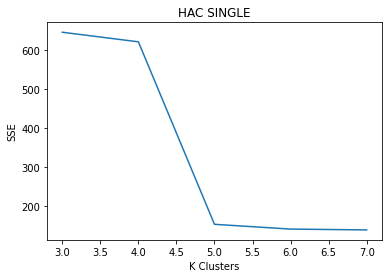

In [73]:
# Iris Classification using single-link
print("----------HAC SINGLE---------- ")
ks = [3,4,5,6,7]
sse_list = []
for k in ks:
    hac = HACClustering(k, 'single').fit(X)
    sse_list.append(hac.total_sse)
plt.plot(ks, sse_list)
plt.title("HAC SINGLE")
plt.xlabel('K Clusters')
plt.ylabel('SSE')
plt.show()


----------HAC COMPLETE ----------


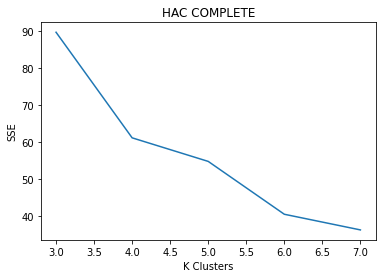

In [71]:
# Iris Classification using complete-link
print("----------HAC COMPLETE ----------")
ks = [3,4,5,6,7]
sse_list = []
for k in ks:
    hac = HACClustering(k, 'complete').fit(X)
    sse_list.append(hac.total_sse)
plt.plot(ks, sse_list)
plt.title("HAC COMPLETE")
plt.xlabel('K Clusters')
plt.ylabel('SSE')
plt.show()

Complete link preformed much better than single link. This is because of a few factors. The Iris data set has 3 distinct output labels. Complete link takes the distance between the farthest elements in clusters, and this forces the clusters from complete link into being "spherical shaped" clusters with a consistent diameter. Single link on the other hand, tends to produce long thinner clusters. The points in the resulting space are most likely clustered in spheres, one for each flower classification, thus the preformance boost for complete link. I did not normalize as the input values were small to begin with.

The more clusters there are the smalled the sse will be, however we wouldn't want more clusters than 3 becuase the data has only 3 output classifications.

## 2.1.2 (5%) Clustering the Iris Classification problem - HAC

Requirements:
- Repeat excercise 2.1.1 and include the output label as one of the input features.

----------HAC SINGLE WITH LABELS----------


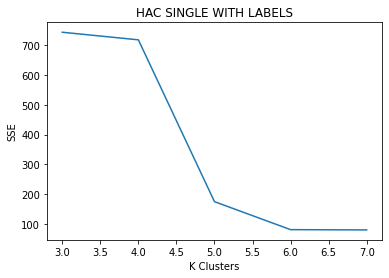

In [76]:
# Clustering Labels using single-link
# Iris Classification using complete-link
print("----------HAC SINGLE WITH LABELS----------")
ks = [3,4,5,6,7]
sse_list = []
for k in ks:
    hac = HACClustering(k, 'single').fit(X_with_labels)
    sse_list.append(hac.total_sse)
plt.plot(ks, sse_list)
plt.title("HAC SINGLE WITH LABELS")
plt.xlabel('K Clusters')
plt.ylabel('SSE')
plt.show()

----------HAC COMPLETE WITH LABELS----------


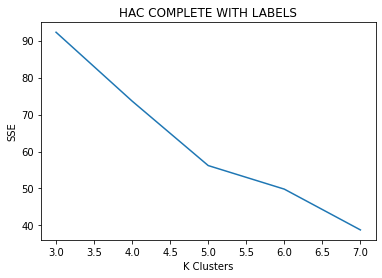

In [77]:
# Clustering Labels using complete-link
# Clustering Labels using single-link
# Iris Classification using complete-link
print("----------HAC COMPLETE WITH LABELS----------")
ks = [3,4,5,6,7]
sse_list = []
for k in ks:
    hac = HACClustering(k, 'complete').fit(X_with_labels)
    sse_list.append(hac.total_sse)
plt.plot(ks, sse_list)
plt.title("HAC COMPLETE WITH LABELS")
plt.xlabel('K Clusters')
plt.ylabel('SSE')
plt.show()

Discuss any differences between the results from 2.1.1 and 2.1.2.

The Complete link preformed better than single link again but they both preformed poorly compared to the HAC models without the inputs included. This is probably due to the method I used to convert the labels into numerical values. Rather than one-hot-encoding the labels I just converted them to numbered labels. My intuitition behind that was that a one-hot-encoded vector wouldn't make a difference when using the euclidean distance metric. The downside to using label encoding is that the numeric values can be misinterpreted as having some sort of order/heiarchy to them. Higher outputs would result in a larger distance.  

## 2.2.1 (7.5%) Clustering the Iris Classification problem: K-Means

Load the Iris Dataset [Iris Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff)

Run K-Means on the Iris dataset using the output label as a feature and without using the output label as a feature

Requirements:
- State whether you normalize your data or not (your choice).  
- Show your results for clusterings using k = 2-7.  
- Graph the total SSE for each k and discuss your results (i.e. what kind of clusters are being made).
---

In [78]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output iris-data.arff
iris_data = arff.loadarff('iris-data.arff')
df = pd.DataFrame(iris_data[0])
df['class'] = (df['class'].str.decode('utf-8'))
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
df['class'] = labelencoder.fit_transform(df['class'])
data = np.array(df, dtype=np.float64)
X_with_labels = copy.deepcopy(data)
X = data[:, 0:-1] 
labels = data[:, -1]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7485  100  7485    0     0   152k      0 --:--:-- --:--:-- --:--:--  152k


----------KMEANS WITHOUT LABEL---------- 


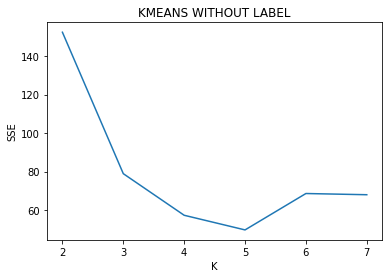

In [83]:
print("----------KMEANS WITHOUT LABEL---------- ")
ks = [2,3,4,5,6,7]
sse_list = []
for k in ks:
    kmc = KMEANSClustering(k, True).fit(X)
    sse_list.append(kmc.total_sse)
plt.plot(ks, sse_list)
plt.title("KMEANS WITHOUT LABEL")
plt.xlabel('K')
plt.ylabel('SSE')
plt.show()

----------KMEANS WITH LABEL---------- 


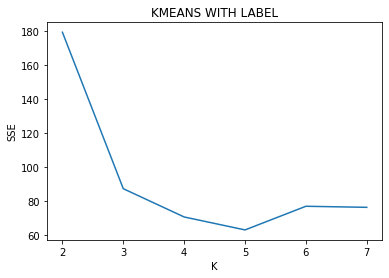

In [85]:
print("----------KMEANS WITH LABEL---------- ")
ks = [2,3,4,5,6,7]
sse_list = []
for k in ks:
    kmc = KMEANSClustering(k, True).fit(X_with_labels)
    sse_list.append(kmc.total_sse)
plt.plot(ks, sse_list)
plt.title("KMEANS WITH LABEL")
plt.xlabel('K')
plt.ylabel('SSE')
plt.show()

Compare results and differences between using the output label and excluding the output label

The Labels didn't help but I suspect that is due to the fact that I only used label encoding.  The best number of k was 5, then the sse increased after that. If I implimented the labels different than I believe they would help describe the space the clusters lie in. 

## 2.2.2 (5%) Clustering the Iris Classification problem: K-Means

Requirements:
- Use the output label as an input feature
- Run K-Means 5 times with k=4, each time with different initial random centroids and discuss any variations in the results. 

----------KMEANS 5 times, k = 4---------- 


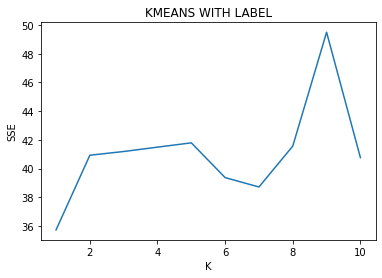

In [89]:
print("----------KMEANS 5 times, k = 4---------- ")
sse_list = []
for i in range(10):
    kmc = KMEANSClustering(k, False).fit(X_with_labels)
    sse_list.append(kmc.total_sse)

plt.plot([1,2,3,4,5,6,7,8,9,10], sse_list)
plt.title("KMEANS WITH LABEL")
plt.xlabel('K')
plt.ylabel('SSE')
plt.show()

I ran KMEANS 10 times out of curiosity to see the different results. The location of the centroids initial location greatly affect the results. Its hard to know what points will give us the best results so randomly testing can give us good results. If I were to actually  implement the algorithm for other projects I would store the best starting centroids for the data sets used to use for later predictions and training. 

## 3.1 (12.5%) Run the SK versions of HAC (both single and complete link) on iris including the output label and compare your results with those above.
Use the silhouette score for this iris problem(k = 2-7).  You may write your own code to do silhouette (optional extra credit) or you can use sklearn.metrics.silhouette_score. Please state if you coded your own silhouette score function to receive the extra credit points (described below). Discuss how helpful Silhouette appeared to be for selecting which clustering is best. You do not need to supply full Silhouette graphs, but you could if you wanted to.

Requirements
- Use the Sillhouette score for this iris problem (k= 2-7) 
- Use at least one other scoring function from [sklearn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) and compare the results. State which metric was used. 
- Possible sklean metrics include (* metrics require ground truth labels):
    - adjusted_mutual_info_score*
    - adjusted_rand_score*
    - homogeneity_score*
    - completeness_score*
    - fowlkes_mallows_score*
    - calinski_harabasz_score
    - davies_bouldin_score
- Experiment using different hyper-parameters. Discuss Results

In [ ]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output iris-data.arff
iris_data = arff.loadarff('iris-data.arff')
df = pd.DataFrame(iris_data[0])
df['class'] = (df['class'].str.decode('utf-8'))
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
df['class'] = labelencoder.fit_transform(df['class'])
data = np.array(df, dtype=np.float64)
X_with_labels = copy.deepcopy(data)
X = data[:, 0:-1] 
labels = data[:, -1]

In [93]:
# Load sklearn
from sklearn import metrics as m
from sklearn.cluster import AgglomerativeClustering

In [97]:
for k in range(2, 8):
    print("K = ", k)
    pred_labels = AgglomerativeClustering(n_clusters= k).fit_predict(X)
    silScore = m.silhouette_score(X, pred_labels)
    amiScore = m.cluster.adjusted_mutual_info_score(labels, pred_labels)
    print("Silhouette score: ",silScore)
    print("Adjusted mutual info score: ", amiScore)


K =  2
Silhouette score:  0.6863930543445408
Adjusted mutual info score:  0.7315847607219574
K =  3
Silhouette score:  0.5540972908150553
Adjusted mutual info score:  0.7671669615713111
K =  4
Silhouette score:  0.4887398491004218
Adjusted mutual info score:  0.7052873669107864
K =  5
Silhouette score:  0.4841553526240121
Adjusted mutual info score:  0.6636220035816015
K =  6
Silhouette score:  0.3618845152256815
Adjusted mutual info score:  0.6071708003966167
K =  7
Silhouette score:  0.34485408962742314
Adjusted mutual info score:  0.6037324340276711


Record Impressions:

I first noticed how the silhouette score decreased as the k increased. This is significan't because it shows that the silhouette score could be a better metric for this dataset. The SSE continued to increase as k increased, but knowing the dataset only had 3 labels I knew that the model needed 3 clusters. 

The other scoring metric I used was the adjusted mutual info score which I was unfamiliar with. The mutual information is a measure of the similarity between two labels of the same data. It samples both clusters and finds 'mutual information'. The adjusted mutual information does that and accounts for chance. A perfect mutual information score is 1 and our best score got up to .76 for k = 3. Unlike the other metrics we tried the adjusted mutual info score was it's highest at when k = 3. Neither SSE or Silhouette score showed k=3 as the best cluster so this could be an even better scoring metric. 

## 3.2 (12.5%) Run the SK version of k-means on iris including the output label and compare your results with those above. 

Use the silhouette score for this iris problem(k = 2-7). You may write your own code to do silhouette (optional extra credit) or you can use sklearn.metrics.silhouette_score. Please state if you coded your own silhouette score function to receive the extra credit points (described below). Discuss how helpful Silhouette appeared to be for selecting which clustering is best. You do not need to supply full Silhouette graphs, but you could if you wanted to.

Requirements
- Use the Sillhouette score for this iris problem (k= 2-7) 
- Use at least one other scoring function form sklearn.metrics and compare the results. State which metric was used
- Experiment different hyper-parameters. Discuss Results

In [99]:
for k in range(2, 8):
    print("K = ", k)
    clusterer = KMeans(n_clusters=k, random_state=10)
    pred_labels = clusterer.fit_predict(X)
    #pred_labels = AgglomerativeClustering(n_clusters= k).fit_predict(X)
    silScore = m.silhouette_score(X, pred_labels)
    amiScore = m.cluster.adjusted_mutual_info_score(labels, pred_labels)
    print("Silhouette score: ",silScore)
    print("Adjusted mutual info score: ", amiScore)


K =  2
Silhouette score:  0.6808136202936816
Adjusted mutual info score:  0.653838071376278
K =  3
Silhouette score:  0.5525919445499757
Adjusted mutual info score:  0.7551191675800485
K =  4
Silhouette score:  0.4978256901095472
Adjusted mutual info score:  0.7172081944051023
K =  5
Silhouette score:  0.4885175508886279
Adjusted mutual info score:  0.6872109247445372
K =  6
Silhouette score:  0.36650401502359653
Adjusted mutual info score:  0.6283901481815655
K =  7
Silhouette score:  0.3583580240469423
Adjusted mutual info score:  0.6643869188548776


*Record impressions*

I was surprised that the silhouette score didn't place k = 3 above k = 2. I know the data set has 3 output labels, and we want to use the model to predict from 3 flowers. However, the fact that the model shows k = 2 as having the highest silhouette score means that we need to use 2 models to get all 3 classifiactions. We could use the first model with k=2 to divide the data into 2 clusterings and then 1 more model to cluster the last 2 flowers. 

Once again the other scoring metric I used was the adjusted mutual information score. K-Means preformed very similar to HAC with complete-link, but the adjusted mutual score is slightly lower for k = 3 for the K-Means model than the ams score for HAC.
# The silhouette score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed clusters
print("For n_clusters = ", n_clusters, "The average silhouette_score is :", silhouette_avg)


## 4. (Optional 5% extra credit) For your silhouette experiment above, write and use your own code to calculate the silhouette scores, rather than the SK or other version. 


*Show findings here*

In [65]:
# Copy function Below

USING HW CODE